In [2]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip install transformers==2.1.1

     |████████████████████████████████| 317kB 6.4MB/s eta 0:00:01
     |████████████████████████████████| 860kB 20.6MB/s 
     |████████████████████████████████| 1.0MB 31.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=7863898e98efaa862fab8931f817c2cad3584f39cb6f9f1d27d3b777e30e7aca
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


In [4]:
!pip install fastai==1.0.58

     |████████████████████████████████| 245kB 6.1MB/s eta 0:00:01
  Found existing installation: fastai 1.0.59
    Uninstalling fastai-1.0.59:
      Successfully uninstalled fastai-1.0.59


In [ ]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle
import math
import random
import os
from pathlib import Path
from functools import partial

In [6]:
# torch
import torch
import torch.optim as optim

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import AdamW

In [ ]:
# Remember to define the model dir in GDrive for persistence if using Colab
MODEL_DIR = Path("drive/My Drive/Colab Notebooks/transformers/MoviePlots/genre_prediction/RoBERTa")

# Prepared data
DATA_FILE = Path("drive/My Drive/Colab Notebooks/transformers/MoviePlots/data/data.pkl")

# Model checkpoints will be stored here
OUTPUT_DIR = MODEL_DIR/'output'
OUTPUT_DIR.mkdir(exist_ok=True)

In [ ]:
# Hyperparameters
SEED = 42
VALID_FRAC = 0.05
USE_FP16 = False
BS = 12

MODEL_TYPE = 'roberta'
MODEL_NAME = 'roberta-base'
MODEL_CLASS = RobertaForSequenceClassification
TOKENIZER_CLASS = RobertaTokenizer
CONFIG_CLASS = RobertaConfig

In [ ]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  # needed
        torch.backends.cudnn.benchmark = False

In [ ]:
seed_all(SEED)

## Import data

In [ ]:
with open(DATA_FILE, 'rb') as handle:
    data = pickle.load(handle)

In [12]:
GENRES = sorted(set([genre for d in data for genre in d['genres']]))

print(GENRES)

['action', 'adult', 'adventure', 'animation', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'family', 'fantasy', 'game-show', 'history', 'horror', 'music', 'musical', 'mystery', 'news', 'reality-tv', 'romance', 'sci-fi', 'short', 'sport', 'talk-show', 'thriller', 'war', 'western']


## Prepare data

In [13]:
df = pd.DataFrame()
df['plot'] = list(map(lambda x: x['plot'], data))
df['genres'] = list(map(lambda x: x['genres'], data))

print(df.shape)
print(df.head())

(117193, 2)
                                                plot        genres
0   #7dayslater is an interactive comedy series f...      {comedy}
1   With just one week left in the workshops, the...  {reality-tv}
2   All of the women start making strides towards...  {reality-tv}
3   All five of these women are independent and s...  {reality-tv}
4   Despite having gone through a life changing p...  {reality-tv}


In [ ]:
class RobertaTokenizerWrapped(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fastai"""
    
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        # As we are not using RNN, we have to limit the sequence length to the model input size.
        # Most of the models require special tokens placed at the beginning and end of the sequences.
        # For some models like RoBERTa, the encoding methods should be called with add_prefix_space set to True.
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        
        # roberta:    [CLS] + prefix_space + tokens + [SEP] + padding
        # fastai will manage padding automatically during the creation of the DataBunch.
        return [CLS] + tokens + [SEP]

In [15]:
roberta_tokenizer = TOKENIZER_CLASS.from_pretrained(MODEL_NAME)
roberta_tokenizer_wrapped = RobertaTokenizerWrapped(pretrained_tokenizer=roberta_tokenizer)
fastai_tokenizer = Tokenizer(tok_func=roberta_tokenizer_wrapped, pre_rules=[], post_rules=[])

100%|██████████| 456318/456318 [00:00<00:00, 1355091.33B/s]


In [16]:
# Test tokenizer
tokens = roberta_tokenizer.tokenize(data[0]['plot'])
print(tokens)

ids = roberta_tokenizer.convert_tokens_to_ids(tokens)
print(ids)

tokens = roberta_tokenizer.convert_ids_to_tokens(ids)
print(tokens)

['#', '7', 'days', 'later', 'Ġis', 'Ġan', 'Ġinteractive', 'Ġcomedy', 'Ġseries', 'Ġfeaturing', 'Ġan', 'Ġensemble', 'Ġcast', 'Ġof', 'ĠYouTube', 'Ġcelebrities', '.', 'ĠEach', 'Ġweek', 'Ġthe', 'Ġaudience', 'Ġwrites', 'Ġthe', 'Ġbrief', 'Ġvia', 'Ġsocial', 'Ġmedia', 'Ġfor', 'Ġan', 'Ġall', '-', 'new', 'Ġepisode', 'Ġfeaturing', 'Ġa', 'Ġwell', '-', 'known', 'Ġguest', '-', 'star', '.', 'ĠSeven', 'Ġdays', 'Ġlater', 'Ġthat', 'Ġweek', "'s", 'Ġepisode', 'Ġpremie', 'res', 'Ġon', 'ĠTV', 'Ġand', 'Ġacross', 'Ġmultiple', 'Ġplatforms', '.']
[10431, 406, 7033, 36600, 16, 41, 10813, 5313, 651, 4246, 41, 12547, 2471, 9, 4037, 8844, 4, 4028, 186, 5, 2437, 5789, 5, 4315, 1241, 592, 433, 13, 41, 70, 12, 4651, 3238, 4246, 10, 157, 12, 6421, 4910, 12, 3641, 4, 7732, 360, 423, 14, 186, 18, 3238, 25548, 1535, 15, 1012, 8, 420, 1533, 4818, 4]
['#', '7', 'days', 'later', 'Ġis', 'Ġan', 'Ġinteractive', 'Ġcomedy', 'Ġseries', 'Ġfeaturing', 'Ġan', 'Ġensemble', 'Ġcast', 'Ġof', 'ĠYouTube', 'Ġcelebrities', '.', 'ĠEach', 'Ġwee

In [ ]:
class RobertaVocab(Vocab):
    "Contain the correspondence between numbers and tokens and numericalize (for RoBERTa)."
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(RobertaVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)

In [ ]:
bert_vocab = RobertaVocab(tokenizer=roberta_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=bert_vocab)
# Remeber to exclude fastai's special tokens which interferes with the [CLS] and [SEP]
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

fastai_processor = [tokenize_processor, numericalize_processor]

In [19]:
databunch = (TextList
             .from_df(df, cols='plot', processor=fastai_processor)
             .split_by_rand_pct(VALID_FRAC, seed=SEED)
             .label_from_df(cols='genres')
             .databunch(bs=BS, pad_first=False, pad_idx=roberta_tokenizer.pad_token_id, path=OUTPUT_DIR))

In [20]:
# Test the Bunch
print('[CLS] token :', roberta_tokenizer.cls_token)
print('[SEP] token :', roberta_tokenizer.sep_token)
print('[PAD] token :', roberta_tokenizer.pad_token)
print('[CLS] id :', roberta_tokenizer.cls_token_id)
print('[SEP] id :', roberta_tokenizer.sep_token_id)
print('[PAD] id :', roberta_tokenizer.pad_token_id)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ', test_one_batch.shape)
print(test_one_batch)

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>
[CLS] id : 0
[SEP] id : 2
[PAD] id : 1
Batch shape :  torch.Size([12, 512])
tensor([[    0,   572,    41,  ...,   530,  9475,     2],
        [    0,    20, 20887,  ...,     4,   104,     2],
        [    0,    20, 13144,  ...,   213,     7,     2],
        ...,
        [    0,   590,     5,  ...,     1,     1,     1],
        [    0, 10664,    73,  ...,     1,     1,     1],
        [    0, 11297,    18,  ...,     1,     1,     1]])


## Train model

In [21]:
!nvidia-smi

Fri Jan  3 19:53:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    32W / 250W |    719MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
class RobertaModel(nn.Module):
    """Wrap transformer model to access only logits."""
    def __init__(self, transformer_model: PreTrainedModel):
        super(RobertaModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        attention_mask = (input_ids!=1).type(input_ids.type()) # Test attention_mask for RoBERTa
        logits = self.transformer(input_ids, attention_mask = attention_mask)[0]   
        return logits

In [23]:
# Update the number of classes and other hyperparams
config = CONFIG_CLASS.from_pretrained(MODEL_NAME)
config.num_labels = len(GENRES)
config.use_bfloat16 = USE_FP16

print(config)

100%|██████████| 473/473 [00:00<00:00, 171425.37B/s]

{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 27,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 1,
  "use_bfloat16": false,
  "vocab_size": 50265
}



In [ ]:
# Download the model
transformer_model = MODEL_CLASS.from_pretrained(MODEL_NAME, config=config)
roberta_model = RobertaModel(transformer_model=transformer_model)

In [121]:
def rescale(arr, new_min, new_max):
    """Rescale old range to new range."""
    return ((arr - arr.min()) * (new_max - new_min)) / (arr.max() - arr.min()) + new_min

# Handle class imbalance in a sensitive way
# Class with highest occurrence => 1 and of lowest occurrence => 10
class_weight = np.array([np.sum(np.array([g in d['genres'] for d in data])) for g in GENRES])
class_weight = rescale(class_weight, 3, 1) # reverse rescale

print(pd.DataFrame({'class_weight': class_weight, 'genre': GENRES}).sort_values(by='class_weight', ascending=False))

    class_weight        genre
1       3.000000        adult
21      2.977438        short
15      2.976696      musical
4       2.942220    biography
25      2.941260          war
22      2.917738        sport
11      2.913417    game-show
13      2.890462       horror
12      2.886491      history
26      2.882171      western
14      2.878854        music
17      2.830500         news
23      2.773419    talk-show
10      2.692684      fantasy
20      2.624823       sci-fi
24      2.616356     thriller
2       2.555653    adventure
3       2.506513    animation
7       2.478103  documentary
16      2.477885      mystery
18      2.464313   reality-tv
0       2.462567       action
6       2.342818        crime
9       2.330468       family
19      2.165899      romance
5       1.524559       comedy
8       1.000000        drama


In [ ]:
# We will use Slanted Triangular Learning Rates, Discriminate Learning Rate and gradually unfreeze the model.
# Use AdamW instead of BertAdam and OpenAIAdam
CustomAdamW = partial(AdamW, correct_bias=False)

pos_weight = torch.FloatTensor(class_weight).cuda()
loss_func = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
accuracy_05 = partial(accuracy_thresh, thresh=0.5)
fscore_05 = partial(fbeta, thresh=0.5)
learner = Learner(databunch, roberta_model, loss_func=loss_func, opt_func=CustomAdamW, metrics=[accuracy_05, fscore_05])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if USE_FP16: learner = learner.to_fp16()

In [123]:
# To use discriminative layer training and gradual unfreezing, split the model into groups.
print(learner.model)

RobertaModel(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features

In [124]:
# For roberta-base
list_layers = [learner.model.transformer.roberta.embeddings,
              *learner.model.transformer.roberta.encoder.layer,
              learner.model.transformer.roberta.pooler]
              
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in', num_groups, 'groups')

Learner split in 14 groups


In [ ]:
seed_all(SEED)

In [ ]:
learner.freeze_to(-1)

In [127]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.75E-04
Min loss divided by 10: 1.74E-04


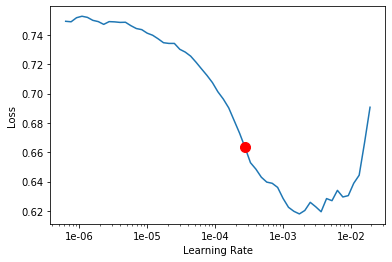

In [128]:
learner.recorder.plot(skip_end=10, suggestion=True)
# A good upper bound is not on the lowest point, but about a factor of 10 to the left.
# A good lower bound is the upper bound, divided by a factor 6.

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.268233,0.255064,0.936881,0.533284,13:34


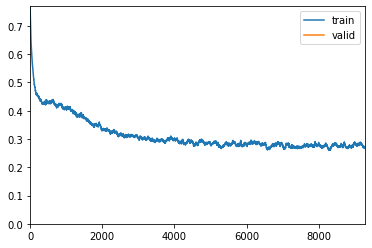

In [129]:
learner.fit_one_cycle(1, max_lr=3e-4, moms=(0.8, 0.7))

In [ ]:
learner.save('first_cycle')

In [ ]:
seed_all(SEED)
learner.load('first_cycle');

In [ ]:
learner.freeze_to(-2)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.248165,0.229991,0.937614,0.619884,14:11


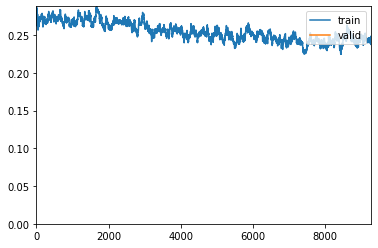

In [133]:
lr = 1e-5
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [ ]:
learner.save('second_cycle')

In [ ]:
seed_all(SEED)
learner.load('second_cycle');

In [ ]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.202711,0.183094,0.949954,0.725017,38:52
1,0.168671,0.163616,0.955416,0.754366,41:54


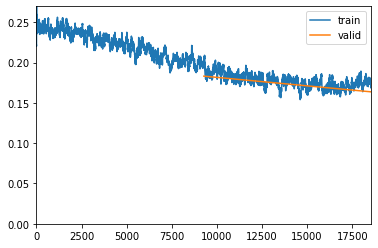

In [137]:
lr = 1e-5
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [ ]:
learner.save('third_cycle')

In [ ]:
learner.load('third_cycle');

## Evaluate model

In [140]:
train_pred, train_true = learner.get_preds(DatasetType.Train)

In [141]:
valid_pred, valid_true = learner.get_preds(DatasetType.Valid)

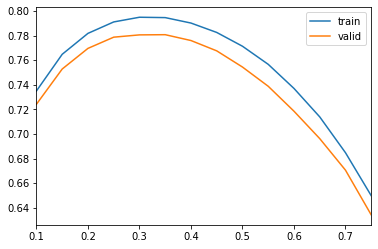

In [142]:
# Which thresh leads to a higher F1 score?
threshes = np.arange(0.1, 0.8, 0.05)
pd.DataFrame([(
    fbeta(y_pred=train_pred, y_true=train_true, thresh=thresh, sigmoid=False).data.item(), 
    fbeta(y_pred=valid_pred, y_true=valid_true, thresh=thresh, sigmoid=False).data.item()
    ) for thresh in threshes], columns=['train', 'valid'], index=threshes).plot()

In [ ]:
opt_thresh = 0.3

In [144]:
print("Train:", accuracy_thresh(y_pred=train_pred, y_true=train_true, thresh=opt_thresh, sigmoid=False))
print("Valid:", accuracy_thresh(y_pred=valid_pred, y_true=valid_true, thresh=opt_thresh, sigmoid=False))

Train: tensor(0.9401)
Valid: tensor(0.9389)


In [ ]:
# Convert tensor to numpy array
valid_true_np = valid_true.detach().cpu().numpy().astype(int)
valid_pred_np = (valid_pred.detach().cpu().numpy() > opt_thresh).astype(int)

In [147]:
from sklearn.metrics import classification_report

# Classification report for genres
true_np = valid_true.detach().cpu().numpy().astype(int)
pred_np = (valid_pred.detach().cpu().numpy() > opt_thresh).astype(int)
report_dict = classification_report(true_np, pred_np, target_names=learner.data.classes, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.drop(["samples avg", "weighted avg", "micro avg", "macro avg"], axis=0)
report_df = report_df.sort_values(by='support', ascending=False)

print(report_df)

             precision    recall  f1-score  support
drama         0.767810  0.903326  0.830073   2255.0
comedy        0.674344  0.893228  0.768504   1639.0
romance       0.621488  0.835556  0.712796    900.0
crime         0.634775  0.900783  0.744738    766.0
family        0.484756  0.837945  0.614196    759.0
documentary   0.565460  0.919940  0.700403    662.0
reality-tv    0.675399  0.922240  0.779750    643.0
mystery       0.491308  0.851030  0.622970    631.0
action        0.495318  0.865794  0.630137    611.0
animation     0.628788  0.917127  0.746067    543.0
adventure     0.407407  0.764826  0.531628    489.0
sci-fi        0.553130  0.846325  0.669014    449.0
thriller      0.352647  0.832547  0.495439    424.0
fantasy       0.416413  0.830303  0.554656    330.0
talk-show     0.631579  0.936170  0.754286    282.0
news          0.551515  0.879227  0.677840    207.0
music         0.527660  0.821192  0.642487    151.0
history       0.406475  0.758389  0.529274    149.0
western     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


## Export model

In [ ]:
# fastai's inference learner cannot retrieve source code for RoBERTa's multiple building blocks so use transformers functionality
learner.model.transformer.save_pretrained(OUTPUT_DIR)

In [149]:
roberta_tokenizer.save_pretrained(OUTPUT_DIR)

('drive/My Drive/Colab Notebooks/transformers/MoviePlots/genre_prediction/RoBERTa/output/vocab.json',
 'drive/My Drive/Colab Notebooks/transformers/MoviePlots/genre_prediction/RoBERTa/output/merges.txt',
 'drive/My Drive/Colab Notebooks/transformers/MoviePlots/genre_prediction/RoBERTa/output/special_tokens_map.json',
 'drive/My Drive/Colab Notebooks/transformers/MoviePlots/genre_prediction/RoBERTa/output/added_tokens.json')

In [ ]:
# Save classes
with open(OUTPUT_DIR/'classes.pkl', 'wb') as fp:
    pickle.dump(learner.data.classes, fp)

In [151]:
!ls "$OUTPUT_DIR"

added_tokens.json  merges.txt	      special_tokens_map.json
classes.pkl	   models	      tokenizer_config.json
config.json	   pytorch_model.bin  vocab.json


## Example inference

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained(OUTPUT_DIR)
model = RobertaForSequenceClassification.from_pretrained(OUTPUT_DIR)
with open(OUTPUT_DIR/'classes.pkl', 'rb') as fp:
    classes = pickle.load(fp)

In [ ]:
def predict_classes(text):
    """Returns the list of predicted genres for the text."""
    input_ids = torch.tensor(tokenizer.encode(text, add_special_tokens=True)).unsqueeze(0)
    logits = model(input_ids)[0]
    probs = torch.sigmoid(logits).detach().cpu().numpy()
    preds = np.array(classes)[np.where(np.any(probs > 0.2, axis=0))[0]].tolist()
    return preds

In [154]:
predict_classes("The affair between a politician and a contemporary dancer is affected by mysterious forces keeping the lovers apart.")

['action',
 'adventure',
 'crime',
 'drama',
 'fantasy',
 'horror',
 'mystery',
 'romance',
 'sci-fi',
 'thriller']

In [155]:
predict_classes("Three buddies wake up from a bachelor party in Las Vegas, with no memory of the previous night and the bachelor missing.")

['action', 'crime', 'drama', 'mystery', 'sci-fi', 'thriller']

In [156]:
predict_classes("An insurance salesman discovers his whole life is actually a reality TV show.")

['comedy', 'drama']

In [157]:
predict_classes("A girl makes a wish on her thirteenth birthday, and wakes up the next day as a thirty-year-old woman.")

['comedy',
 'drama',
 'fantasy',
 'horror',
 'mystery',
 'romance',
 'sci-fi',
 'thriller']

In [158]:
predict_classes("A computer hacker learns from mysterious rebels about the true nature of his reality and his role in the war against its controllers.")

['action',
 'adventure',
 'drama',
 'fantasy',
 'horror',
 'mystery',
 'sci-fi',
 'thriller']

## References

- [Fastai with 🤗Transformers (BERT, RoBERTa, XLNet, XLM, DistilBERT)](https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2)
- [Hugging Face Transformers GitHub](https://github.com/huggingface/transformers)
- [Fastai documentation](https://docs.fast.ai/text.html)
- [A Tutorial to Fine-Tuning BERT with Fast AI](https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/)
- [Using RoBERTa with Fastai for NLP](https://medium.com/analytics-vidhya/using-roberta-with-fastai-for-nlp-7ed3fed21f6c)
- [Dealing with imbalanced datasets in pytorch - PyTorch Forums](https://discuss.pytorch.org/t/dealing-with-imbalanced-datasets-in-pytorch/22596/21)